In [3]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 2

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [4]:
# 臨床データ（アウトカム）
df_MB = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_MB.pkl"
).set_index("PATIENT_ID")

# 遺伝子発現データ（インプット）
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


# important to decide X_dict name
SET_DF_MICROARRAY = (
    df_mrna_agilent_microarray,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
)

In [5]:
# 結合

df_merged = pd.merge(
    df_MB[["OS_STATUS", "OS_MONTHS"]],
    rename_duplicated_columns(SET_DF_MICROARRAY[INDEX_MICROARRAY]),
    right_index=True,
    left_index=True,
)
df_merged["OS_STATUS_INT"] = df_merged["OS_STATUS"].replace(
    {"0:LIVING": 0, "1:DECEASED": 1}
)

In [6]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

genes_list = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"][
    "X15"
].columns

# Draw KM line

to use OS_MONTHS and OS_STATUS, read raw patient data

In [7]:
def plot_KM(target: str, threshold: float = 0, is_save: bool = False):
    ax = None
    df_merged["target_gene"] = df_merged[target].apply(
        lambda x: 1 if x > threshold else -1
    )
    plt.figure()
    kmf = KaplanMeierFitter()
    for name, group in df_merged.groupby("target_gene"):
        kmf.fit(
            group["OS_MONTHS"],
            event_observed=group["OS_STATUS_INT"],
            label="is deceased: {0}".format(name),
        )
        ax = kmf.plot(ax=ax) if ax else kmf.plot()

    make_dir(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR)

    plt.title(target)
    plt.savefig(
        "{0}/{1}.png".format(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR, target)
    ) if is_save else plt.show()

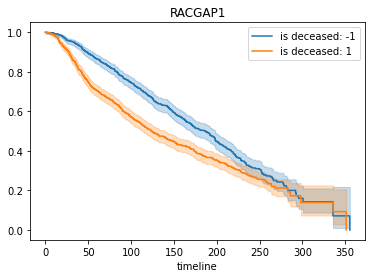

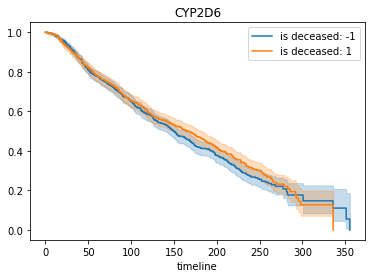

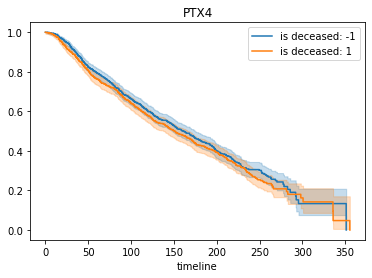

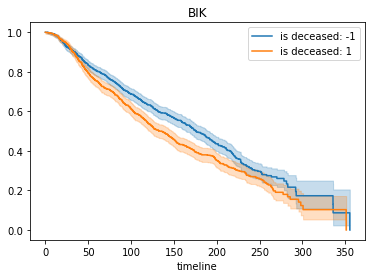

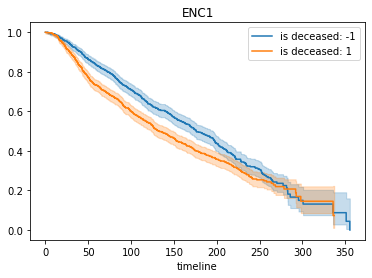

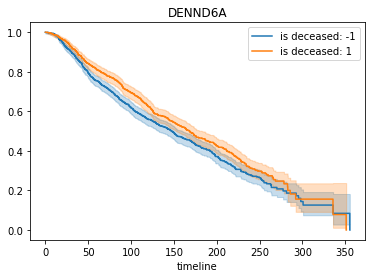

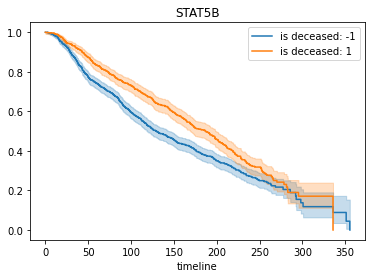

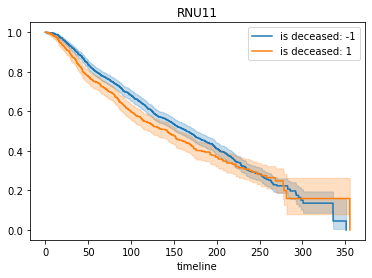

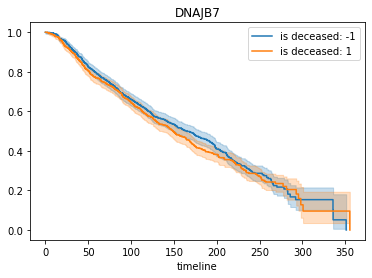

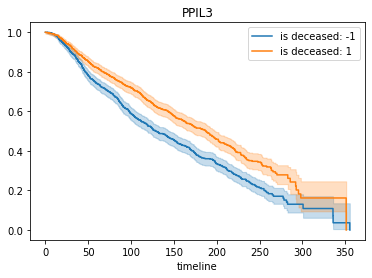

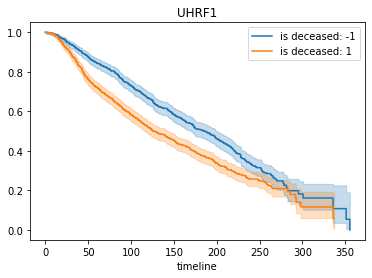

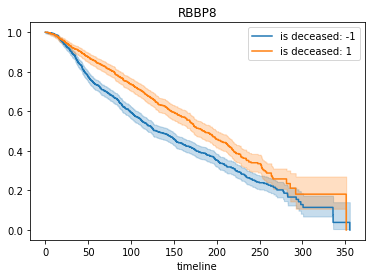

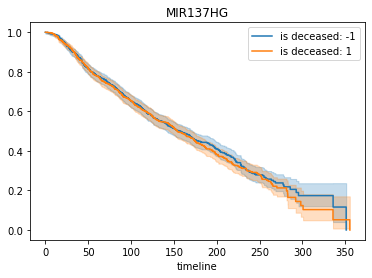

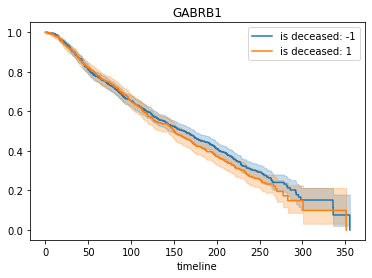

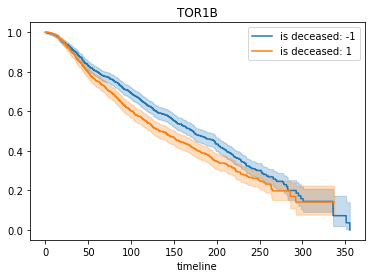

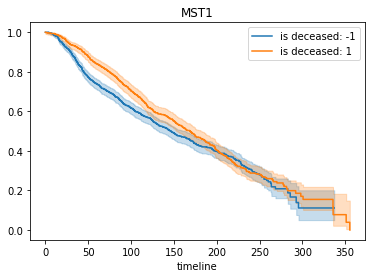

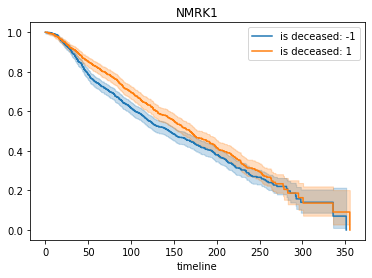

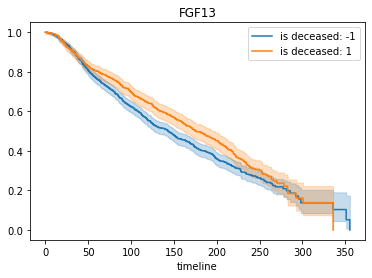

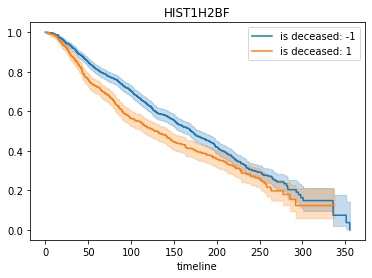

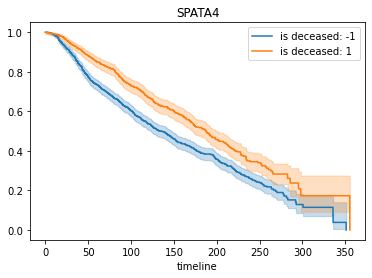

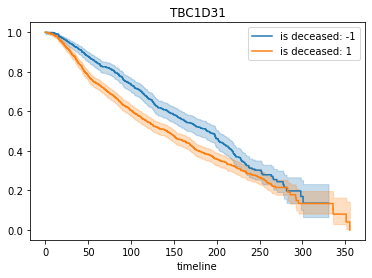

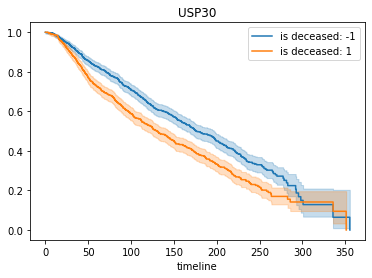

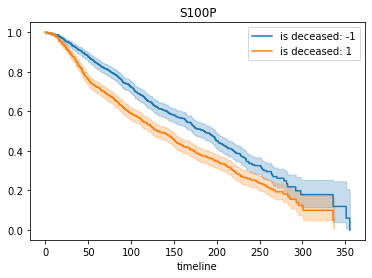

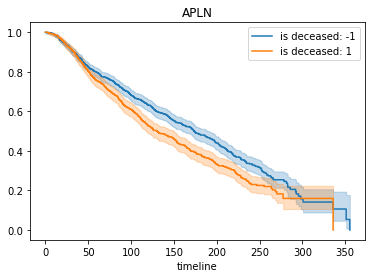

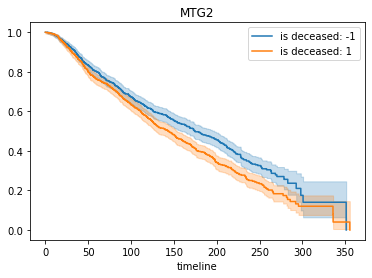

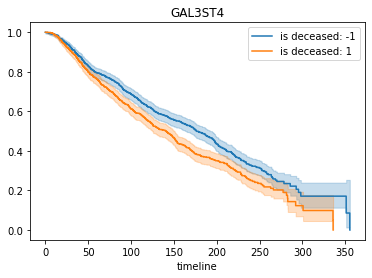

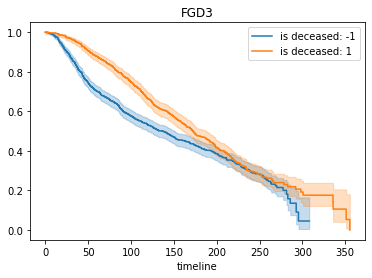

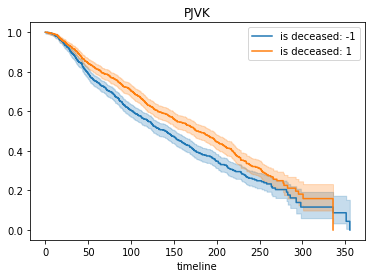

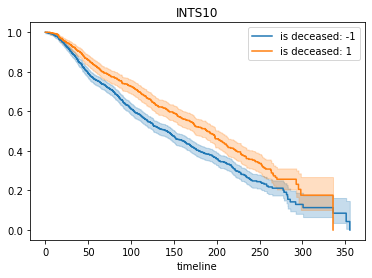

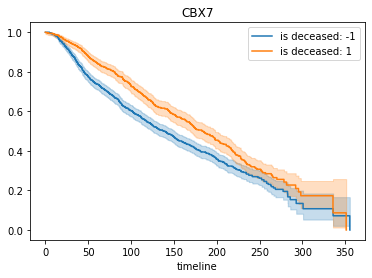

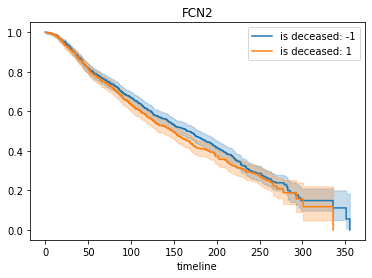

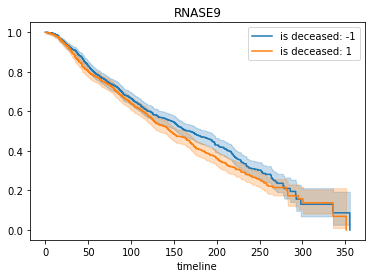

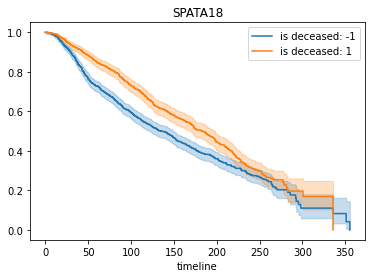

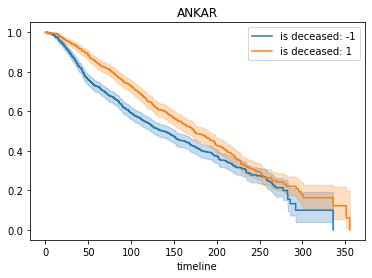

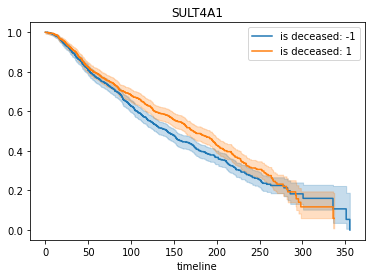

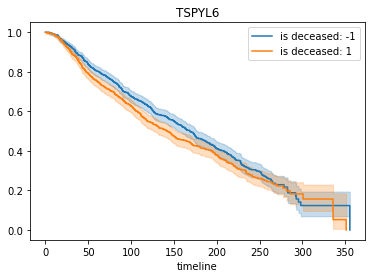

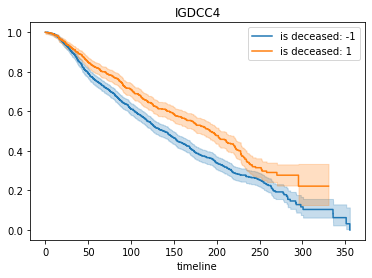

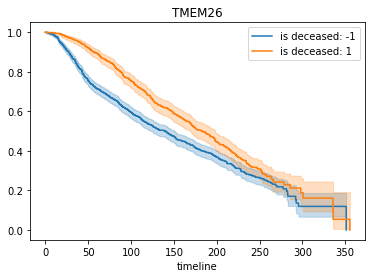

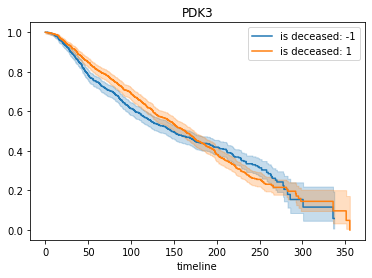

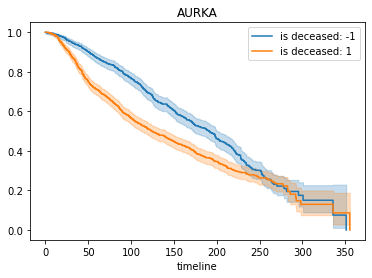

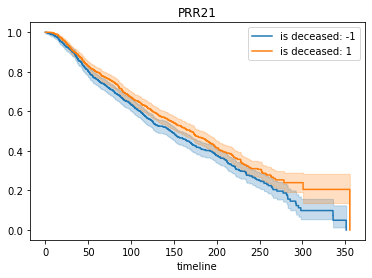

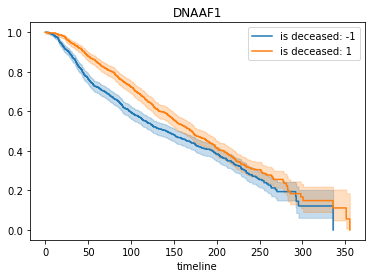

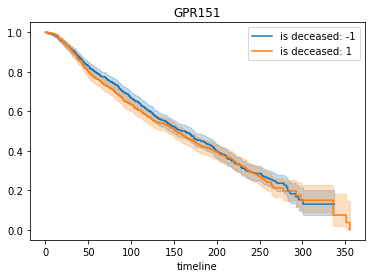

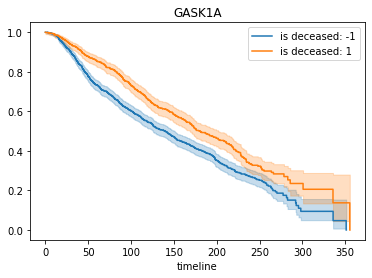

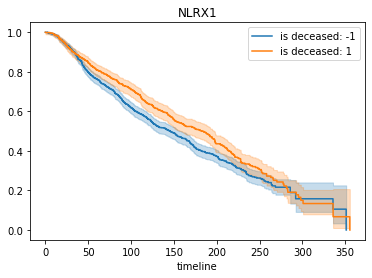

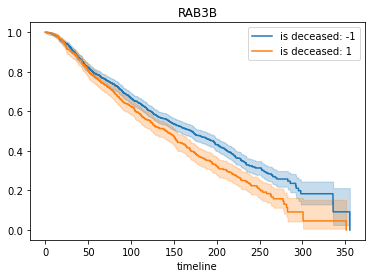

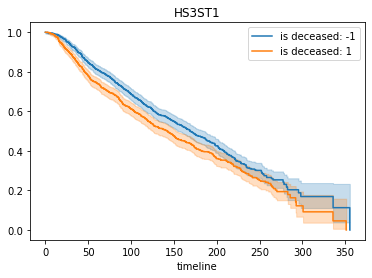

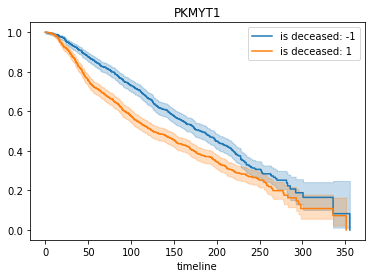

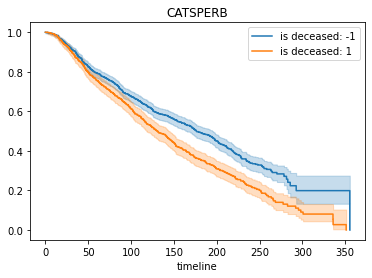

In [8]:
for t in genes_list:
    plot_KM(t, 0, is_save=True)

# Draw Cox proportional hazard model

## dupulicated genes between all microarray

Iteration 1: norm_delta = 0.26942, step_size = 0.9500, log_lik = -7538.19414, newton_decrement = 43.39730, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.02405, step_size = 0.9500, log_lik = -7494.52573, newton_decrement = 0.30353, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00145, step_size = 0.9500, log_lik = -7494.22131, newton_decrement = 0.00107, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -7494.22025, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 1904 total observations, 801 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_INT'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 1103
   partial log-likelihood = -7494.22
         time fit was run = 2022-09-07 06:28:20 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RNASE9      0.11       1.11       0.03             0.05             0.17                 1.05                 1.18
SULT4A1    -0.11       0.90       0.03            -0.17            -0.04                 0.84                 0.96
ENC1        0.15       1.16       0.03             0.09             0.21                 1.10                 1.23
MTG1        0.07       1.07       0.03             0.02             0.12                 1.02                 1.13
STAT5B     -0.14       0.87       0.03            -0.20            -0.08                 0.82                 0.92

            cmp to     z      p   -log2(p)
covariate                                 
RNASE9        0.00  3.47 <0.005      10.93
SULT4A1       0.00 -3.04 <0.005       8.71
ENC1          0.00  5.07 <0.005      21.29
MTG1          0.00  2.52   0.01       6.43
STAT5B        0.00 -4.91 <0.005      20.04
---
Concordance = 0.60
Partial AIC = 14998.44
log-likelihood ratio test = 87.95 on 5 df
-log2(p) of ll-ratio test = 55.61

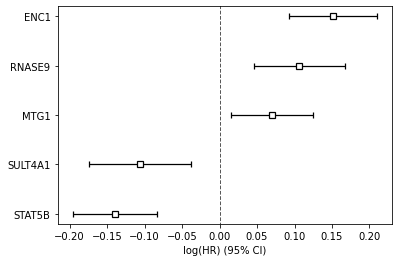

In [9]:
cph = CoxPHFitter()
cph.fit(
    df_merged[
        ["RNASE9", "SULT4A1", "ENC1", "MTG1", "STAT5B", "OS_MONTHS", "OS_STATUS_INT"]
    ],
    duration_col="OS_MONTHS",
    event_col="OS_STATUS_INT",
    show_progress=True,
)
cph.print_summary()
cph.plot()
plt.savefig(config.FIGURES_VALGENES_PROGNOSIS_CROSS_DIR + "/cph.png")

# plot genes 

In [19]:
df_cross = pd.read_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)

<AxesSubplot:xlabel='STAT5B', ylabel='Count'>

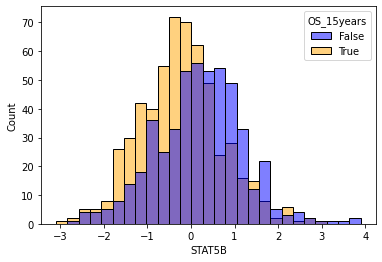

In [20]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)